<a href="https://colab.research.google.com/github/Tsyhankova/goit_python/blob/main/HW_9_tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектура нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [47]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [48]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [49]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return y

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(num_features, n_hidden_1)
    # Место для вашего кода

    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Выходной слой
    self.out = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Место для вашего кода
    x = tf.nn.sigmoid(self.layer_1(x))
    x = tf.nn.sigmoid(self.layer_2(x))
    x = tf.nn.softmax(self.out(x))
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов
    return x

In [50]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [51]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

In [52]:
# Функция обучения нейросети
def train(neural_net, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
  trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
  gradients = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [53]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)

        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss.numpy())
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc.numpy())
        
print(accuracy_history)
print(loss_history)

[0.62890625, 0.765625, 0.8515625, 0.8203125, 0.875, 0.8828125, 0.85546875, 0.87109375, 0.87109375, 0.88671875, 0.87109375, 0.88671875, 0.87890625, 0.94140625, 0.8984375, 0.8359375, 0.9453125, 0.890625, 0.8828125, 0.90625, 0.88671875, 0.9375, 0.91796875, 0.9296875, 0.89453125, 0.91796875, 0.9296875, 0.9296875, 0.953125, 0.9453125]
[380.64252, 214.5624, 129.68112, 142.8059, 121.775894, 120.20326, 130.18118, 125.86294, 123.8284, 88.517586, 122.04172, 94.27651, 109.21462, 54.68008, 86.03905, 151.86526, 41.03578, 98.72754, 83.81563, 72.1515, 101.99649, 79.14323, 55.454414, 67.362625, 90.06244, 59.032604, 56.40062, 59.791737, 42.744324, 46.178516]


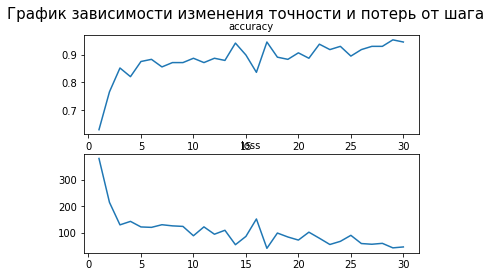

In [54]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

fig, axs = plt.subplots(2, 1)
step = np.arange(1,31)
axs[0].plot(step, accuracy_history, label='accuracy')
axs[1].plot(step, loss_history, label='loss')
axs[0].set_title('accuracy', fontsize=10)
axs[1].set_title('loss', fontsize=10)
fig.suptitle('График зависимости изменения точности и потерь от шага', fontsize=15)
plt.show()

In [55]:
# Вычислите точность обученной нейросети

pred = neural_net(x_test)
print("Accuracy: ", accuracy(pred, y_test).numpy())

Accuracy:  0.9042


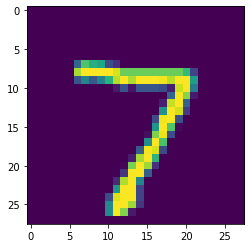

Ответ нейросети:  7


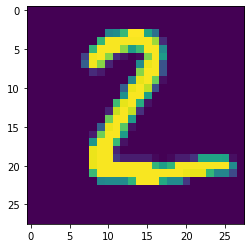

Ответ нейросети:  2


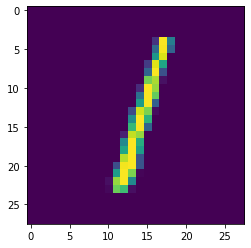

Ответ нейросети:  1


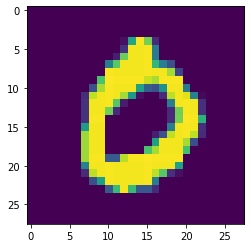

Ответ нейросети:  0


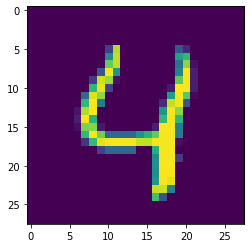

Ответ нейросети:  4


In [56]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

predictions = neural_net(x_test)

for i in range(5):
    plt.imshow(np.reshape(x_test[i], [28, 28]))
    plt.show()
    print("Ответ нейросети: ", np.argmax(predictions.numpy()[i]))

На выбранной тестовой выборке ошибок не было. 
